In [6]:
!export NLTK_DATA=/home/mlyang721/nltk_data


In [1]:
import pandas as pd
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk import word_tokenize
from nltk.corpus import stopwords
import gensim.downloader as api
import matplotlib.pyplot as plt

glove_model = api.load("glove-wiki-gigaword-100")
import nltk
import os

nltk.data.path.append('/home/mlyang721/nltk_data')

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')




[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mlyang721/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mlyang721/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mlyang721/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
llama_result = pd.read_csv('results/result-meta-llama-Llama-3.1-8B-Instruct.csv')
yi_result = pd.read_csv('results/result-01-ai-Yi-Coder-9B-Chat.csv')
phi_result  = pd.read_csv('results/result-microsoft-Phi-3-mini-128k-instruct.csv')
gemma_result = pd.read_csv('results/result-google-codegemma-7b.csv')
pd.set_option('display.max_colwidth', None)

In [3]:
model_names = [
    "meta-llama/Llama-3.1-8B-Instruct",
    "01-ai/Yi-Coder-9B-Chat",
    "microsoft/Phi-3-mini-128k-instruct",
    "google/codegemma-7b"
]
results_dir = 'results'

In [4]:
def text_to_vector(text):
    """
    Converts a given text into a vector using pre-trained GloVe embeddings. The process involves tokenizing 
    the text, filtering out stopwords and non-alphabetic words, and averaging the vectors of the remaining words.

    Parameters:
    text (str): The input text to convert into a vector.

    Returns:
    np.ndarray: A vector representing the mean of all word vectors from the text, or a zero vector if no valid words are present.
    """
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stopwords.words('english')]
    word_vectors = [glove_model[word] for word in words if word in glove_model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(glove_model.vector_size)

def calculate_max_cosine_similarity_with_sliding_window(df, column1, column2):
    vectors1 = df[column1].apply(text_to_vector)
    vectors2 = df[column2].apply(text_to_vector)
    shorter_vectors, longer_vectors = vectors1, vectors2
    
    shorter_matrix = np.stack(shorter_vectors.values)
    
    similarities = []
    
    for start in range(len(longer_vectors) - len(shorter_matrix) + 1):
        window_matrix = np.stack(longer_vectors[start:start + len(shorter_matrix)].values)
        window_similarities = cosine_similarity(shorter_matrix, window_matrix).diagonal()
        mean_similarity = np.mean(window_similarities)
        
        similarities.append(mean_similarity)
    max_similarity = max(similarities)
    avg_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)
    return avg_similarity, std_similarity


# Load results and compute similarity
results = [pd.read_csv(os.path.join(results_dir, f"result-{model_name.replace('/', '-')}.csv")) for model_name in model_names]
labels = ['Llama', 'Yi', 'Phi', 'Gemma']

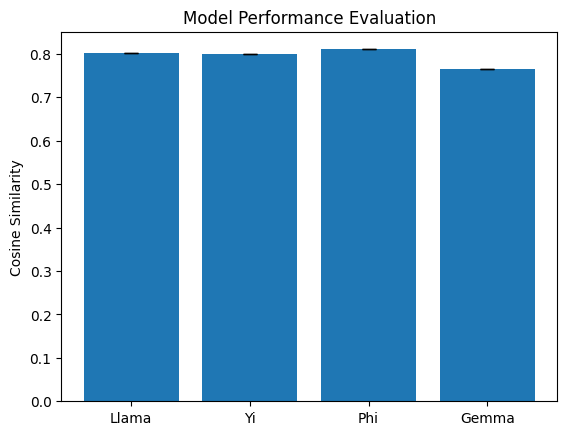

In [5]:
scores, std_devs = [], []
for df, model_name in zip(results, model_names):
    avg_sim, std_sim = calculate_max_cosine_similarity_with_sliding_window(df, 'canonical_solution', f"Fixed Code ({model_name})")
    scores.append(avg_sim)
    std_devs.append(std_sim)

x = np.arange(len(labels))
fig, ax = plt.subplots()
ax.bar(x, scores, yerr=std_devs, capsize=5)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Cosine Similarity')
ax.set_title('Model Performance Evaluation')

# Save the figure as a PNG file
plt.savefig("model_performance_evaluation.png")

# Display the figure
plt.show()

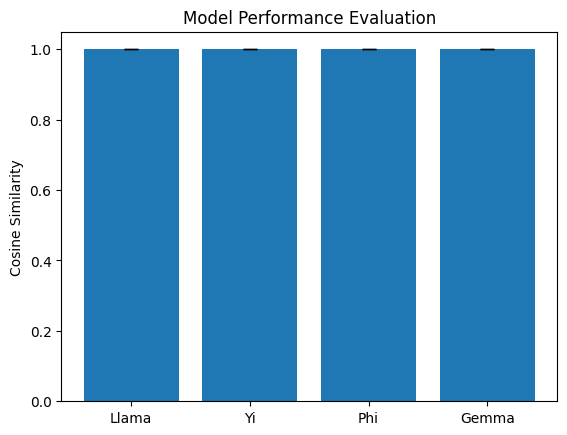

In [6]:
scores, std_devs = [], []
for df, model_name in zip(results, model_names):
    avg_sim, std_sim = calculate_max_cosine_similarity_with_sliding_window(df, 'canonical_solution', "Noisy_Code")
    scores.append(avg_sim)
    std_devs.append(std_sim)

x = np.arange(len(labels))
fig, ax = plt.subplots()
ax.bar(x, scores, yerr=std_devs, capsize=5)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Cosine Similarity')
ax.set_title('Model Performance Evaluation')

# Save the figure as a PNG file
plt.savefig("masked_code_evaluation.png")

# Display the figure
plt.show()